# Wave propagation (hyperbolic PDE)

## libs

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy import fft, ifft

## initialization

In [168]:
n = 2
COURANT = 0.3
T = 10
X_max = T / 2
X_min = - X_max
T_min = 0

NUMBER_X = 100
NUMBER_T = 200

T_max =  COURANT * (X_max - X_min) * NUMBER_T / NUMBER_X + T_min

In [169]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X + 1)
T_RANGE = np.linspace(T_min, T_max, NUMBER_X + 1)
K_RANGE = np.linspace(- NUMBER_X * np.pi / T, NUMBER_X * np.pi / T, NUMBER_X + 1)

X_STEP = X_RANGE[1] - X_RANGE[0]
T_STEP = T_RANGE[1] - T_RANGE[0]
X, T = np.meshgrid(X_RANGE, T_RANGE, indexing='ij')

In [170]:
def animation_plot(E):
    fig, ax = plt.subplots(figsize=(10, 5))
    #ax.axis([X_min, X_max, E.min(), E.max()])

    l1, = ax.plot(X[:,0], E[:, 10], lw=3, color='black')
    ax.grid(c='#aaaaaa', ls='--')

    ax.set_ylabel("f(x)")
    ax.set_xlabel("x")

    def animate(i):
        l1.set_data(X[:,0], E[:, i])
        l1.set_label('t = ' + '%.3f' % (i * T_STEP))

        legend = plt.legend(loc='upper right')
        return l1, legend

    ani = animation.FuncAnimation(fig, animate, frames= np.arange(0, NUMBER_X, 5), interval=60)

    #ani.save("solution.mp4")
    return HTML(ani.to_jshtml())

def hermite(n, x):
    if n == 0:
        return 1
    if n == 1:
        return x
    if n == 2:
        return x ** 2 - 1

def potential(X):
    return X ** 2 /2

def exact_solution(X):
    psi = np.zeros_like(X)
    psi = (np.exp(- 1j * (n + 1/2) * T) * 
           (np.math.factorial(n) * 2 ** n * np.sqrt(np.pi)) ** -0.5 *
           np.exp(- potential(X[:, 0])) *
           hermite(n, X[:, 0]))

    

## initial state

In [175]:
psi = np.zeros_like(X, dtype=complex)
psi[:, 0] = ((np.math.factorial(n) * 2 ** n * np.sqrt(np.pi)) ** -0.5 *
            np.exp(- potential(X[:, 0])) *
            hermite(n, X[:, 0]))

## main procedure

In [176]:
for i in range(len(X_RANGE)-1):
    
    u = np.exp(np.identity(X.shape[0]) * (-1j * potential(X_RANGE)) * T_STEP / 2) @ psi[:, i]
    ind = np.arange(1, len(psi[:, i+1]), 2, dtype=int)
    u[ind] *= (-1)
    u = fft(u)
    u *= np.exp(-1j * T_STEP * K_RANGE[n] / 2)
    u[ind] *= (-1)
    u = ifft(u)
    u = np.exp(np.identity(X.shape[0]) * (-1j * potential(X_RANGE)) * T_STEP / 2) @ u
    psi[:, i+1] = u
    

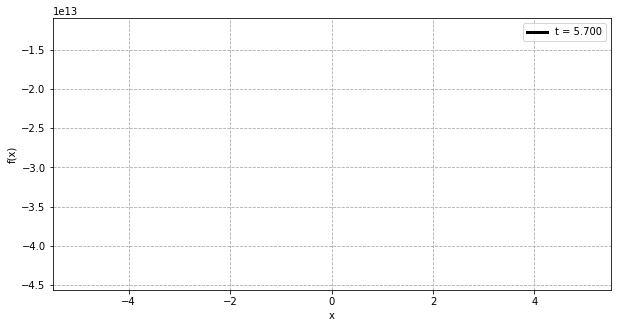

In [177]:
animation_plot(np.imag(psi))